<a href="https://colab.research.google.com/github/kdenning/Political-ANN/blob/master/CIS_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting voting preference using ANN**



# Background

## Research Question

Can participant voter preference be predicted by the language they use to describe a target individual who is in their political out-group using an Artificial Neural Network (ANN) algorithm?

## Data

In this project, I used a dataset collected shortly after the U.S. 2016 Presidential Election. The initial purpose of this study was to examine whether a perspective taking manipulation would reduce the amount people stereotype their political out-group and increase the amount they see out-group targets as similiar to themselves. The out-group target in this particular study was a white women named Jen who appeared to be in her mid-thirties, picked because she fit with a population that swung between voting for both Trump and Clinton. The perspective taking manipulation administered was unsucessful as determined by a manipulation check that found no difference between perspective taking or control instructions. However, all participants wrote about the typical day in the life of Jen (just with people in the perspective taking condition being provided additional instructions to put themselves in the "other person's shoes"). These narratives were open-ended and could be as long or as short as the participant desired.

## How the text data will be used

I am going to take each word in each participant's narrative and find a GloVe (Global Vectors for Word Representation) vector for it. GloVe vectors provide context for each word, specifically finding the numerical representation of the 300 words contextually closest to that word. More information on GloVE vectors can be found [here](https://nlp.stanford.edu/projects/glove/). I will only be using words that are alpha words and not stop words according to Spacy's dictionary. GloVe vectors are also already a part of Spacy's nlp. 



# **Data Set-up**

In [51]:
# importing the data
import pandas as pd
outgroups = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTwyrGxIIFsk-dZ8ovO8XMTLhO0_MV6fZQz8MrPqrevtN0Oi2PLm6G-I5g9Xg-o7BxbuxY5hYGmj_nL/pub?output=csv'
pt_table = pd.read_csv(outgroups, error_bad_lines=False, encoding='utf-8', delimiter=",")
pd.set_option('display.max_columns', None)
pt_table.head()

,subid,PoliOrient_1,VotePref,Day_Clin_Out_PT,Day_Clin_Out_C,Day_Trump_Out_PT,Day_Trump_Out_C
0,1,2,1,NaN,Jen gets up and feeds her 5 kids. She goes to ...,NaN,NaN
1,4,5,2,NaN,NaN,NaN,I BELIEVE A TYPICAL DAY FOR JEN IS FILLED WITH...
2,8,2,1,Jen is a SAHM with four kids. She gets up ever...,NaN,NaN,NaN
3,9,2,1,NaN,She is a housewife and mother to a large famil...,NaN,NaN
4,14,3,2,NaN,NaN,NaN,Jen's typical day consists of teaching her Gen...


In [52]:
# getting data in long format
table_long = pd.melt(pt_table, id_vars=['subid', 'VotePref'], value_vars=['Day_Clin_Out_PT', 'Day_Clin_Out_C', 'Day_Trump_Out_PT', 'Day_Trump_Out_C'])
# removing NaN's
long_nonan = table_long.dropna()
# checking the data looks right and is the right number of rows; should be 382
print(long_nonan.head())
print(len(long_nonan))

    subid  VotePref         variable  \
2       8         1  Day_Clin_Out_PT   
6      16         1  Day_Clin_Out_PT   
7      17         1  Day_Clin_Out_PT   
11     26         1  Day_Clin_Out_PT   
17     41         1  Day_Clin_Out_PT   

                                                value  
2   Jen is a SAHM with four kids. She gets up ever...  
6   Jen started her day on Facebook railing agains...  
7   Jen typical day is taking her kids to school. ...  
11  Jen continues to tune into the most local poli...  
17  Jen is a nurse in an E.R in Montana. She works...  
382


In [53]:
# Looking at the types of variables in my set, so that I can recode VotPref using the correct function
print(long_nonan.dtypes)

subid        int64
VotePref     int64
variable    object
value       object
dtype: object


In [54]:
# make the outcome variable binary (1, 0)
binary = long_nonan.replace({'VotePref': 2}, 0) # Now 1 = voted for Clinton, 0 = voted for Trump
binary

,subid,VotePref,variable,value
2,8,1,Day_Clin_Out_PT,Jen is a SAHM with four kids. She gets up ever...
6,16,1,Day_Clin_Out_PT,Jen started her day on Facebook railing agains...
7,17,1,Day_Clin_Out_PT,Jen typical day is taking her kids to school. ...
11,26,1,Day_Clin_Out_PT,Jen continues to tune into the most local poli...
17,41,1,Day_Clin_Out_PT,Jen is a nurse in an E.R in Montana. She works...
...,...,...,...,...
1505,764,0,Day_Trump_Out_C,"Jen wakes up, turns on CNN to get her talking ..."
1509,769,0,Day_Trump_Out_C,"Lives in the city. Wakes up, drive a compact c..."
1513,778,0,Day_Trump_Out_C,She gets up and goes to work.\nShe is sadden b...
1518,790,0,Day_Trump_Out_C,Jen just got done fighting a crowd of Right ...


In [55]:
# Getting puddles and spacy loaded
!rm -r  'uo_puddles'
puddles = 'uo-puddles' 
clone_url = f'https://github.com/{puddles}/uo_puddles.git'
!git clone $clone_url 
import uo_puddles.uo_puddles as up

import spacy
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()  

Cloning into 'uo_puddles'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 282 (delta 2), reused 0 (delta 0), pack-reused 276
Receiving objects: 100% (282/282), 76.59 KiB | 220.00 KiB/s, done.
Resolving deltas: 100% (169/169), done.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [56]:
# Adding my github repo of functions for this final project that I have written previously
!rm -r  'python_library_final_proj'
github_name = 'kdenning' 
clone_url = f'https://github.com/{github_name}/python_library_final_proj.git'
!git clone $clone_url
import python_library_final_proj.functions as func

Cloning into 'python_library_final_proj'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [57]:
# Shuffle table to prep for data split
import numpy as np
rsgen = np.random.RandomState(1234)

shuffled_table = binary.sample(frac=1, random_state=rsgen).reset_index(drop=True)
shuffled_table.head()

# Pulling out strings
text = shuffled_table['value'].tolist()
vote = shuffled_table['VotePref'].tolist() 

print(text[:10])

['Jen is highly motivated to prove she is an independent, hard working person. She is a single parent of two children, both girls, and she wants them to growup knowing there is nothing that they can\'t do, so spends her day role modelling for them how she thinks a modern, free-thinker, conscientous woman would behave. She is environmentally aware, teaching them about recycling but dumps her trash in the neighbor\'s front yard because she doesn\'t believe the same way. As she tells her girls sometimes you have to do bad things to get the right thing done. She doesn\'t understand why her girls are so disrepectful of her forgetting they were standing by when she yelled "Pig" at the cop who pulled her over for running that red light on her way to their school. She joins a group of her peers after lunch to discuss how they can make it as difficult as possible for the republicans to do anything that might change their wanted status quo. She has been unfairly treated and it is up to them to r

In [58]:
# Getting GloVe vectors for words in shuffled text list
text_vectors = []

for i in range(len(text)):
  output = func.sent2vec(text[i])
  text_vectors.append(output)

CPU times: user 6.91 s, sys: 22.6 ms, total: 6.93 s
Wall time: 6.94 s


In [79]:
# checking out the GloVe vectors
print(text_vectors[:10])
len(text_vectors)

[[-0.14161106995365855, 0.05998000160119013, -0.19024690046399548, 0.014654524571297668, 0.004348193482448689, 0.056371486828297, 0.04784788603929779, -0.079822216946278, 0.016986428665680977, 2.228563161590431, -0.19442895026523857, 0.003177445081263026, -0.07297238668639071, -0.0019502927456345833, -0.10588627107311747, 0.001528854319778613, -0.0735356026458778, 0.7094638559825813, -0.07212166999808595, 0.05612158037344866, 0.008662957058559302, -0.13159361529853666, 0.01351521208976643, -0.009892684761199016, -0.004480092353010668, 0.08657417306087062, -0.011748081527037334, -0.024431937011666124, 0.066672535484975, -0.14105262004923594, -0.12334203449832394, 0.0828192352046129, -0.029386592816702927, -0.013319651944020504, 0.18918615299213642, -0.016517702224841224, 0.08894808793181105, -0.05486774543238379, -0.07131398786330902, -0.05549499818677955, 0.03047137871337465, 0.0055752348425927795, 0.0028646626344681543, 0.06077396008038681, -0.06381255936148707, -0.016143708928971538,

382

# Finding the score to beat

As is seen below, the score to beat to demonstrate our model is better than chance is 0.6173913043478261.

In [80]:
# Split data into test and training sets
X_train = text_vectors[:267]
Y_train = vote[:267]

X_test = text_vectors[267:]
Y_test = vote[267:] 

# Score to beat with ANN model
Y_test.count(1)/len(Y_test)

0.6173913043478261

In [82]:
Y_test[:20]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]

# Grid Searches

In [69]:
# Do grid search for best nodes and hidden layer amounts
up.grid_search([[64,1], [32, 1], [32,16,1], [16, 8, 1], [64, 32, 1], [64, 32, 16, 1], [128, 64, 32, 1], [128,1]], [10,15,20,30, 40, 50,75, 100], X_train, Y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1) ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1), total=   1.6s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1), total=   1.6s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(64, 1), total=   1.5s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   1.6s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   1.5s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 1), total=   1.5s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 16, 1) ........
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 16, 1), total=   1.6s
[CV] batch_size=1, epochs=10, input_dim=300, lyrs=(32, 16, 1) ........
[CV]  batch_size=1, epochs=10, input_dim=300, lyrs=(32, 16, 1), total=   1.6s
[CV] batch_size=1, epochs=10, input_dim=300, lyr

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 17.0min finished


Best: 0.700375 using {'batch_size': 1, 'epochs': 75, 'input_dim': 300, 'lyrs': (128, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (64, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (32, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (32, 16, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (16, 8, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (64, 32, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (64, 32, 16, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (128, 64, 32, 1)}
0.625468 (0.055299) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 300, 'lyrs': (128, 1)}
0.576779 (0.037077) with: {'batch_size': 1, 'epochs': 15, 'input_dim': 300, 'lyrs': (64, 1)}
0.629213 (0.060159) with: {'batch_size': 1, '

# Running the model

The best model from the grid search resulted in a score of 0.700375 using {'batch_size': 1, 'epochs': 75, 'input_dim': 300, 'lyrs': (128, 1)}. This is the model I am going to use.

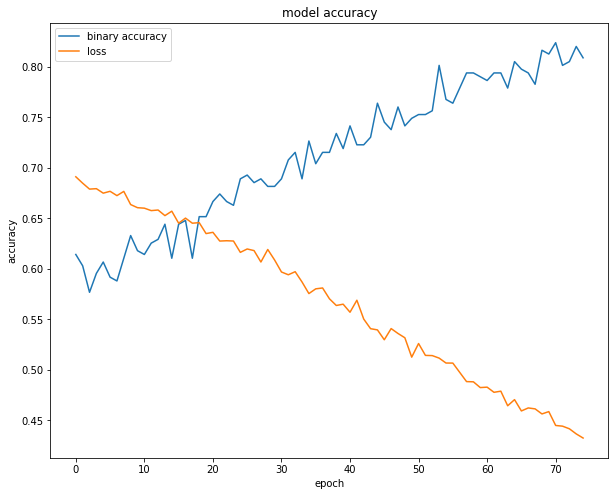

In [83]:
# Choosing the best model
m = up.ann_build_model(300, [128,1]) 

# The best epochs
training = up.ann_train(m, X_train, Y_train, 75) 

In [84]:
# Looking at what the accuracy scores are looking like
training.history['binary_accuracy'][-10:]

[0.7977527976036072,
 0.7940074801445007,
 0.7827715277671814,
 0.8164793848991394,
 0.812734067440033,
 0.8239700198173523,
 0.8014981150627136,
 0.8052434325218201,
 0.8202247023582458,
 0.8089887499809265]

# Predictions

In [85]:
# Predictions at 75 total epochs
raw_predictions = m.predict(X_test)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, Y_test))

(cases.count((0,0)) + cases.count((1,1)))/len(X_test)

0.7043478260869566

The score to beat was 0.6173913043478261, so we beat it by almost .8! Seems like this model is doing okay at predicting voter preference.

# Conclusions

This model did better than the score we needed to beat, getting a predictive accuracy score of 0.7043478260869566 by using GloVe vectors of the words people wrote about their political out-group to predict who they voted for in the 2016 U.S. Presidential Election. This could be helpful when developing a profile of people's political leaning based on language use.

However, one caveat is that the algorithm could be biased in only picking up certain trigger words, namely if the participants actually wrote about whether the target was conservative or liberal and then predicting the participant voted opposite. Though some participants never mentioned it and instead described stereotypically liberal or conservative things (e.g., watching CNN versus Fox News), there could have been enough explicit descriptions for the algorithm to pick-up on. It might be helpful to look at a wider source of text information people write in order to predict their political identity, such as overall tweets or descriptions of a variety of targets, not just their political out-group.